In [1]:
# MinMaxScaler, no One Hot input vectors, no Sigmoid, BCELossWithLogitsLoss (with weight), Cross Validation
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import time

start_time = time.perf_counter()

torch.manual_seed(42) # Reproduzierbarkeit des Shuffles im DataLoader


In [2]:
# 1. Load tha data Goal: Load the dataset from a CSV and extract features and labels.

data_path = "T_Stueck_Gesamt.csv"

data = pd.read_csv(data_path, sep=';', decimal=',')
# Extract labels and features
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# Separation into single values and time series (3 single values + 15 sequence values)
static_features = X[:, [0, 1, 7]]        # max_force, avg_force, avg_speed
force_seq = X[:, 2:7]                    # Columns 4-8 (Force)
speed_seq = X[:, 8:13]                   # Columns 10-14 (Speed)
dist_seq = X[:, 13:18]                   # Columns 15-19 (Distance)
sequence_features = np.stack([force_seq, speed_seq, dist_seq], axis=1)  # → (Samples, 3, 5)



In [3]:
# 2. CNN Model Define a 1D CNN model in PyTorch that processes both sequential and static input data.
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, ceil_mode=True)
        self.fc1 = nn.Linear(16 * 3 + 3, 64)  # +3 because of the static features
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x_seq, x_static):
        x = torch.relu(self.conv1(x_seq))   # (B, 16, 5)
        x = self.pool(x)                    # (B, 16, 2)
        x = x.view(x.size(0), -1)           # (B, 48)
        x = torch.cat((x, x_static), dim=1) # (B, 51)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)

In [4]:
# 3 Cross-Validation Setup Set up 5-fold stratified cross-validation and initialize result containers.
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_test_probabilities = []
misclassified_samples = []
total_conf_matrix = np.zeros((2, 2))
all_training_losses = []
test_losses = []

In [5]:
#  4. Fold Loop - Training and Evaluation Goal: For each fold, preprocess, train, and evaluate.
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):

    # Create training and test sets for this fold
    X_train_seq, X_test_seq = sequence_features[train_idx], sequence_features[test_idx]
    X_train_static, X_test_static = static_features[train_idx], static_features[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Normalization per channel separately
    X_train_seq_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
    X_test_seq_flat = X_test_seq.reshape(X_test_seq.shape[0], -1)

    scaler_seq = MinMaxScaler()
    X_train_seq_flat = scaler_seq.fit_transform(X_train_seq_flat)
    X_test_seq_flat = scaler_seq.transform(X_test_seq_flat)
    X_train_seq = X_train_seq_flat.reshape(-1, 3, 5)
    X_test_seq = X_test_seq_flat.reshape(-1, 3, 5)

    scaler_static = MinMaxScaler()
    X_train_static = scaler_static.fit_transform(X_train_static)
    X_test_static = scaler_static.transform(X_test_static)

    # Convert to PyTorch tensors
    X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
    X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
    X_train_static = torch.tensor(X_train_static, dtype=torch.float32)
    X_test_static = torch.tensor(X_test_static, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Creation of the TensorDataset and DataLoader for training
    train_dataset = TensorDataset(X_train_seq, X_train_static, y_train)
    train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)

    # Calculation of class weights
    class_counts = torch.tensor([(y_train == 0).sum(), (y_train == 1).sum()], dtype=torch.float32)
    pos_weight = class_counts[0] / class_counts[1]

    # Initialize the model
    model = CNNModel()

    # Training configuration
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    epochs = 100
    training_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_seq_batch, X_static_batch, y_batch in train_loader:
            outputs = model(X_seq_batch, X_static_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        training_losses.append(epoch_loss / len(train_loader))

    all_training_losses.append(training_losses)

    # Test run and collect metrics
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_seq, X_test_static)
        test_probs = torch.sigmoid(test_outputs)
        test_pred = (test_probs >= 0.5).float()
        test_loss = criterion(test_outputs, y_test).item()
        test_losses.append(test_loss)
        conf_matrix = confusion_matrix(y_test.numpy(), test_pred.numpy())

    total_conf_matrix += conf_matrix

    all_test_probabilities.extend(zip(test_idx, test_probs.numpy()))

    # Save misclassified samples
    for i, (true_label, predicted_label) in enumerate(zip(y_test.numpy(), test_pred.numpy())):
        if true_label != predicted_label:
            misclassified_samples.append({
                'Index': int(test_idx[i])+1,
                'True Label': int(true_label),
                'Predicted Label': int(predicted_label),
                'Error Type': 'FP' if predicted_label == 1 else 'FN'
            })

end_time = time.perf_counter()
total_time = end_time - start_time

Predicted probabilities in original order:
Sample 1: 0.6896
Sample 2: 0.9081
Sample 3: 0.8748
Sample 4: 0.9200
Sample 5: 0.8637
Sample 6: 0.8963
Sample 7: 0.9069
Sample 8: 0.9179
Sample 9: 0.9114
Sample 10: 0.8411
Sample 11: 0.9246
Sample 12: 0.8614
Sample 13: 0.9118
Sample 14: 0.9479
Sample 15: 0.8454
Sample 16: 0.7635
Sample 17: 0.8803
Sample 18: 0.8959
Sample 19: 0.7940
Sample 20: 0.8642
Sample 21: 0.7859
Sample 22: 0.9249
Sample 23: 0.8863
Sample 24: 0.9203
Sample 25: 0.9328
Sample 26: 0.8840
Sample 27: 0.9147
Sample 28: 0.8998
Sample 29: 0.8844
Sample 30: 0.9082
Sample 31: 0.8735
Sample 32: 0.9052
Sample 33: 0.8992
Sample 34: 0.8528
Sample 35: 0.9527
Sample 36: 0.1658
Sample 37: 0.5039
Sample 38: 0.6000
Sample 39: 0.0013
Sample 40: 0.2247
Sample 41: 0.1390
Sample 42: 0.0007
Sample 43: 0.8522
Sample 44: 0.3876
Sample 45: 0.3848
Sample 46: 0.4420
Sample 47: 0.5987
Sample 48: 0.3917
Sample 49: 0.0005
Sample 50: 0.0000
Sample 51: 0.8894
Sample 52: 0.9136
Sample 53: 0.9120
Sample 54: 0

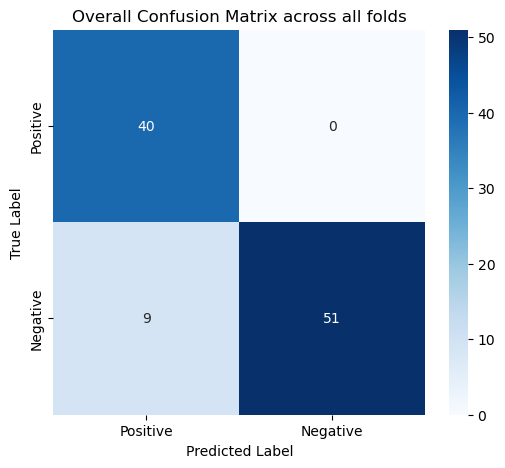

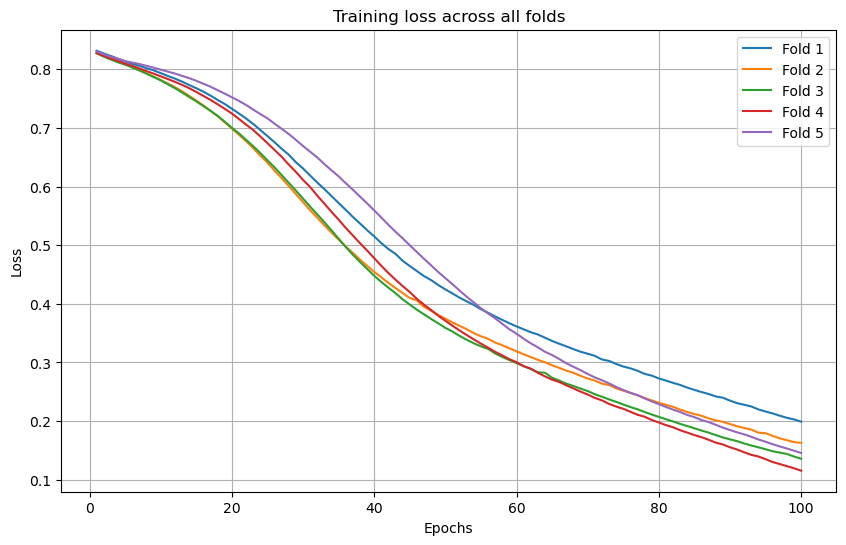

In [6]:
# 5. Post-Processing and Results Goal: Summarize results and visualize outcomes.
# Bring results back into the original order
all_test_probabilities.sort(key=lambda x: x[0])  # Sort by original index
sorted_probabilities = [prob for _, prob in all_test_probabilities] # Extract probabilities


# Output the probabilities
print("Predicted probabilities in original order:")
for i, prob in enumerate(sorted_probabilities, start=1):
    print(f"Sample {i}: {prob:.4f}")

# Output misclassified samples
print("Incorrectly classified samples:")
for sample in misclassified_samples:
    print(f"Index: {sample['Index']}, True Label: {sample['True Label']}, Predicted Label: {sample['Predicted Label']}, Error Type: {sample['Error Type']}")

# Output overall results
TP = total_conf_matrix[1, 1]
TN = total_conf_matrix[0, 0]
FP = total_conf_matrix[0, 1]
FN = total_conf_matrix[1, 0]
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
avg_test_loss = np.mean(test_losses)

print(f'Gesamtergebnis: Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Test Loss: {avg_test_loss:.4f}, Zeit: {total_time:.4f}')

# Plot overall confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(total_conf_matrix[[1, 0]][:, [1, 0]].astype(int), annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix across all folds')
plt.show()

# Plot training losses across all folds
plt.figure(figsize=(10, 6))
for fold, losses in enumerate(all_training_losses):
    plt.plot(range(1, epochs + 1), losses, label=f'Fold {fold + 1}')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss across all folds")
plt.legend()
plt.grid()
plt.show()